<a href="https://colab.research.google.com/github/adx17/DEEP_LEARNING/blob/main/CNN_RECYCLE_ORGANIC_CLASSIFICATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# ===============================
# Step 1: Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# ===============================
# Step 2: Unzip Dataset
# ===============================
import zipfile
import os

# Updated paths for your setup
zip_path = "/content/drive/MyDrive/Waste_Classification_folder/Waste_Classification.zip"
extract_path = "/content/waste_classification/unzipped"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted to:", extract_path)


✅ Dataset extracted to: /content/waste_classification/unzipped


In [40]:
# ===============================
# Step 3: Split into TRAIN/TEST
# ===============================
import random
import shutil

# Original dataset inside the ZIP
original_path = os.path.join(extract_path, "Waste Classification Dataset", "waste_dataset")
classes = ['organic', 'recyclable']

# TRAIN and TEST folders
train_path = os.path.join(extract_path, "TRAIN")
test_path = os.path.join(extract_path, "TEST")

for folder in [train_path, test_path]:
    for cls in classes:
        os.makedirs(os.path.join(folder, cls), exist_ok=True)

# Split 80/20
for cls in classes:
    cls_folder = os.path.join(original_path, cls)
    images = [f for f in os.listdir(cls_folder) if f.endswith(('.jpg','.png','.jpeg'))]
    random.shuffle(images)
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    for img in train_images:
        shutil.move(os.path.join(cls_folder, img), os.path.join(train_path, cls, img))
    for img in test_images:
        shutil.move(os.path.join(cls_folder, img), os.path.join(test_path, cls, img))

print("✅ Dataset successfully split into TRAIN and TEST")


✅ Dataset successfully split into TRAIN and TEST


TRAIN folders: ['recyclable', 'organic']
TEST folders: ['recyclable', 'organic']


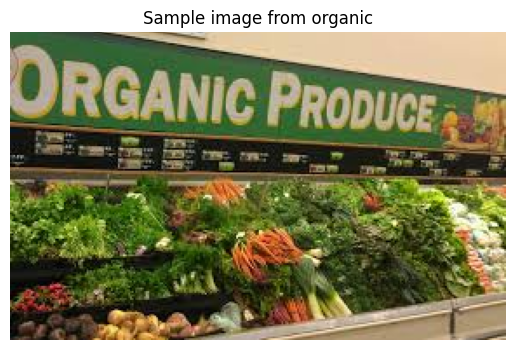

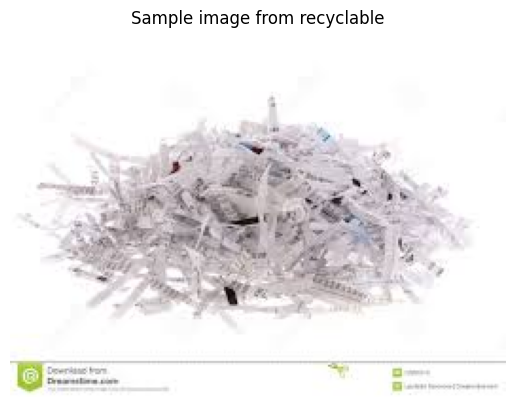

In [41]:
# ===============================
# Step 4: Verify and Display Sample Images
# ===============================
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random

# Check TRAIN/TEST folders
print("TRAIN folders:", os.listdir(train_path))
print("TEST folders:", os.listdir(test_path))

# Display one sample image from each class
for cls in classes:
    cls_folder = os.path.join(train_path, cls)
    img_files = [f for f in os.listdir(cls_folder) if f.endswith(('.jpg','.png','.jpeg'))]
    if img_files:
        sample_img = random.choice(img_files)
        img_path = os.path.join(cls_folder, sample_img)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Sample image from {cls}")
        plt.axis('off')
        plt.show()


In [42]:
# ===============================
# Step 5: Import Libraries & Prepare Data
# ===============================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=(128, 128),
                                               batch_size=32,
                                               class_mode='binary')

test_data = test_datagen.flow_from_directory(test_path,
                                             target_size=(128, 128),
                                             batch_size=32,
                                             class_mode='binary')


Found 24516 images belonging to 2 classes.
Found 12099 images belonging to 2 classes.


In [43]:
# ===============================
# Step 6: Build CNN Model
# ===============================
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# ===============================
# Step 7: Train Model
# ===============================
history = model.fit(train_data,
                    epochs=5,
                    validation_data=test_data)


Epoch 1/5
767/767 ━━━━━━━━━━━━━━━━━━━━ 555s 724ms/step - accuracy: 0.8263 - loss: 0.4136 - val_accuracy: 0.8468 - val_loss: 0.3603
Epoch 2/5
767/767 ━━━━━━━━━━━━━━━━━━━━ 544s 709ms/step - accuracy: 0.8409 - loss: 0.3805 - val_accuracy: 0.8483 - val_loss: 0.3607
Epoch 3/5
767/767 ━━━━━━━━━━━━━━━━━━━━ 541s 704ms/step - accuracy: 0.8501 - loss: 0.3636 - val_accuracy: 0.8597 - val_loss: 0.3410
Epoch 4/5
767/767 ━━━━━━━━━━━━━━━━━━━━ 550s 717ms/step - accuracy: 0.8516 - loss: 0.3549 - val_accuracy: 0.8718 - val_loss: 0.3144
Epoch 5/5
767/767 ━━━━━━━━━━━━━━━━━━━━ 541s 706ms/step - accuracy: 0.8574 - loss: 0.3401 - val_accuracy: 0.8701 - val_loss: 0.3228


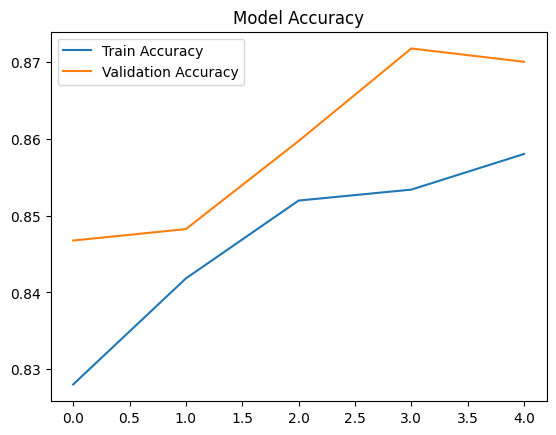

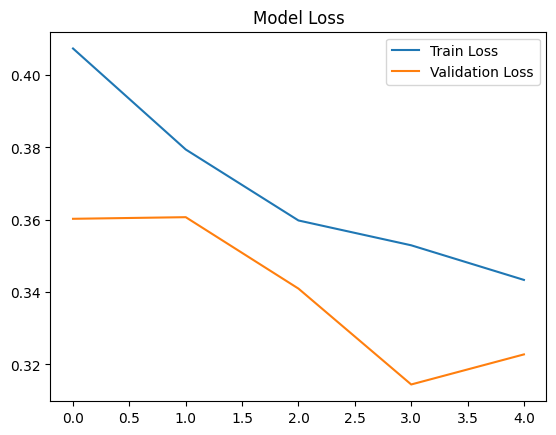

In [46]:
# ===============================
# Step 8: Plot Accuracy & Loss
# ===============================
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Model Loss")
plt.show()


In [50]:
# ===============================
# Step 9: Test on a New Image
# ===============================
from tensorflow.keras.preprocessing import image
import numpy as np

# Change the path to any image in TEST folder
img_path = os.path.join(test_path, 'recyclable', os.listdir(os.path.join(test_path,'recyclable'))[0])
img = image.load_img(img_path, target_size=(128,128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)

if prediction[0][0] > 0.5:
    print("♻️ Recyclable Waste")
else:
    print("🚮 Non-Recyclable Waste")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
♻️ Recyclable Waste


In [51]:
# ===============================
# Step 10: Save Trained Model
# ===============================
model_save_path = "/content/drive/MyDrive/Waste_Classification_folder/models/waste_classifier.h5"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print("✅ Model saved to Google Drive:", model_save_path)


✅ Model saved to Google Drive: /content/drive/MyDrive/Waste_Classification_folder/models/waste_classifier.h5
